### **MA5204: Aprendizaje de Máquinas**

**Departamento de Ingeniería Matemática, Universidad de Chile**

**Profesor:** Felipe Tobar

**Ayudantes:** Alejandro Cuevas, Mauricio Araneda, Mauricio Romero

*Verificado 27 abril 2023*

## Kernel Methods

En este notebook es muestran ejemplos de codigo de los siguientes métodos:

* kernel ridge regression.
* Kernel adaptive filters, kernel least mean squares (KLMS)
* Support vector machines (SVM) , regressión y clasificación

In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# permite compilar funciones de python a C
from numba import jit

In [24]:
# configuracion graficos
sns.set()  # estilo por defecto de seaborn
sns.set_context('notebook', font_scale=1.5) # contexto notebook 
sns.set_style('whitegrid')  # estilo de los graficos
plt.rcParams['figure.figsize'] = (12, 5) # tamaño por defecto de las figuras

# Kernel ridge regression

Utiliza el _truco del kernel_ para poder transformal una regresión lineal en una no lineal.

__Modelo:__ $$\hat{y}(x') = \Phi(x')^T \hat{w} = \sum_{i=1}^{n}\alpha_i \mathcal{k}(x', x_i) $$

__Función objetivo:__ $$J = \frac{1}{2}\sum_{i=1}^{N} \left( y_i - w \Phi(x_i) \right)^2 + \rho ||w||^2  $$

__Entrenamiento:__ $$ \alpha =  \mathcal{K}^{-1}(X, X) Y $$ 

__cargar datos__

In [25]:
# elegir 2 para otro data set
dataset_select = 1

if dataset_select == 1:
#     data = np.loadtxt('../datos/gauss2.csv')
    data = np.loadtxt('../datos/wool.csv', delimiter=',')
    x = data[:, 0]
    y = data[:, 1]
elif dataset_select == 2:
    data = fetch_mldata('mauna-loa-atmospheric-co2').data
    x = data[:, 1]
    y = data[:, 0]

In [26]:
# transforma shape del input para que quede de dimensiones n_inputs x n_features
x = x.reshape(-1, 1)

__modelo, entrenamiento y test__

In [43]:
from sklearn.kernel_ridge import KernelRidge

# Elegir si se quiere interpolación o predicción
# inter | pred (interpolación y predicción)
mode = 'pred'

# proporción de conjunto de entrenamiento
prop = 0.4 

if mode == 'inter':
    train_points = np.sort(np.random.choice(len(x), int(len(x) * prop), replace=False))
elif mode == 'pred':
    train_points = np.arange(int(len(x) * prop))

    
gamma = 0.005
# Instanciamos
krr = KernelRidge(kernel='rbf', alpha = 0.05,  gamma=gamma)  
#recalll alpha = 0.10, 


# Ajuste
krr.fit(x[train_points, :], y[train_points])  

# Predicción
y_hat = krr.predict(x)

__Graficamos__

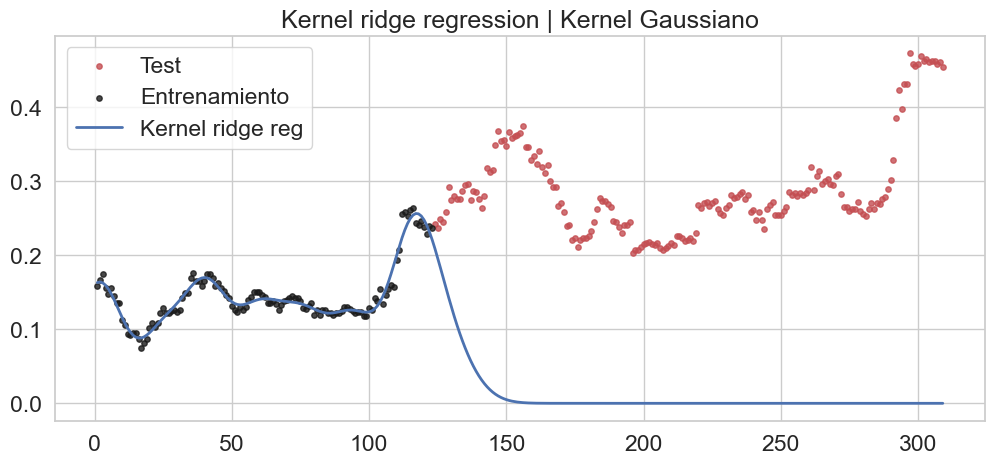

In [44]:
# máscara para graficar puntos de test
mask = np.ones_like(y).astype(bool)
mask[train_points] = False

plt.scatter(x[mask], y[mask], c='r', alpha=0.8, s=15, label='Test')
plt.scatter(x[train_points], y[train_points], c='k', alpha=0.8, s=15, label='Entrenamiento')
plt.plot(x, y_hat, label='Kernel ridge reg', lw=2)
plt.legend()
plt.title('Kernel ridge regression | Kernel Gaussiano');

# Kernel adaptive filter (KAF)

Método adaptivo de filtrado, funciona de forma __online__, donde va almacenando elementos en un diccionario $D$ del cual dependen las predicciones. La intuición detras de esto es que los elementos del diccionario deben ser lo suficientemente representativos para poder predecir puntos futuros, diferentes variantes del método radican en el criterio de eleccción de elementos del diccionario.

[tutorial univ. of athens (Nikolaos Mitsakos 2012)](https://www.math.uh.edu/~razencot/MyWeb/docs/workshop/NicolaosMitsakos_KernelRegression.pdf)

se van recibiendo los datos de forma secuencial.

Datos de la forma: $$ (x_n, y_n)_{n=1}^{N}$$ 
Predicción: $$ \hat{y}_n(x_n) = \phi^T(X_{n-1}) W = \sum_{k=1}^{M}\mu e_k \mathcal{k}(x_n, x_k)$$

donde: 
* $\mu$ es la taza de aprendizaje (learning rate) 
* $e_k = y_k - \hat{y}_k$
* Se tienen $M$ elementos guardados en el diccionario

usando la regla adaptiva:
$$ w_{i+1} = w_{i} + \mu e_i x_i$$

Y en ese caso se tiene 

$$w_n = \mu \sum_{i=1}^{n} e_i \phi(x_i)  $$

Notar que con esa expresión de $w_n$ se recupera la expresión de la predicción.

___

__¿Cómo elegir los puntos (centros) y tomar solo elementos importantes?__

__Platt's novelty criterion:__
* Dado el diccionario en el instante $D_{n-1}$.
* Para cada punto nuevo $x_n$, tomar la menor distancia a los elementos existentes $ dist_n = \min\limits_{u_k \in D_{n-1}} \{||x_n - u_k|| \}$.
* si $dist_n < \delta_1$, no se agrega $D_n = D_{n-1}$.
* si $dist_n \geq \delta_1$, se calcula $e_n$.
* Si $|e_n| \geq \delta_2$, $x_n$ se agrega al diccionario.

In [45]:
  # decorador para compilar la función en C
@jit
def kernel_rbf(x, y, gamma=0.1):
    """
    Retorna la evaluación del kernel rbf K(x,y) con el gamma dado
    """
    return np.exp(-gamma * np.linalg.norm(x-y) ** 2)


def kernel_dict_apply(x, D, gamma=0.1):
    """
    Retorna vector de evaluar el kernel en el punto x
    con cada punto del diccionario.
    K(x, x_i), con x_i en el diccionario
    """
    out = np.zeros(D.shape[0])
    for i, center in enumerate(D):
        out[i] = kernel_rbf(x, center, gamma)
    return out

__Algoritmo NKLMS__

Pequeña modificación que normaliza $a_i = \mu e_i$ con $a_i = \frac{\mu e_i}{K(x_i, x_i)}$.

In [46]:
# inicialización

# output
y_klms = np.zeros(len(x))  
# dictionario de puntos, n_dict x n_features
D = np.empty((0, x.shape[1]))  
# errores historicos
err = np.empty((0, 1))  

# Parametros del modelo

# learning rate
mu = 0.8
# parametro kernel
gamma = 2e-3
# platt's treshold 1
delta_1 = 0.015
# platt's treshold 2
delta_2 = 0.02

# inicio del filtro
for i in range(len(x)):
    if i == 0:
        y_klms[i] = 0  # valor inicial, no hay muestras pasadas
        err = np.append(err, y[i] - y_klms[i])  # error a priori
        D = np.vstack((D, x[i]))  # agregar elemento al dict
        continue  # pasa a la siguiente iteración
    else:
        # prediccion
        a_n =  err[:] * mu / kernel_rbf(x[i], x[i], gamma=gamma)
        y_klms[i] = kernel_dict_apply(x[i], D, gamma) @ a_n
    # sparsification criterion
    # Platt's  novelty criterion
    dist_n = sp.spatial.distance.cdist(x[i].reshape(1, 1), D).min()
    if dist_n >= delta_1:
        e_n = y[i] - y_klms[i]  # error de prediccion
        if np.abs(e_n) >= delta_2:
            err = np.append(err, e_n)
            D = np.vstack((D, x[i]))  # agregar elemento al dict

print('Tamaño final diccionario', D.shape)

Tamaño final diccionario (146, 1)


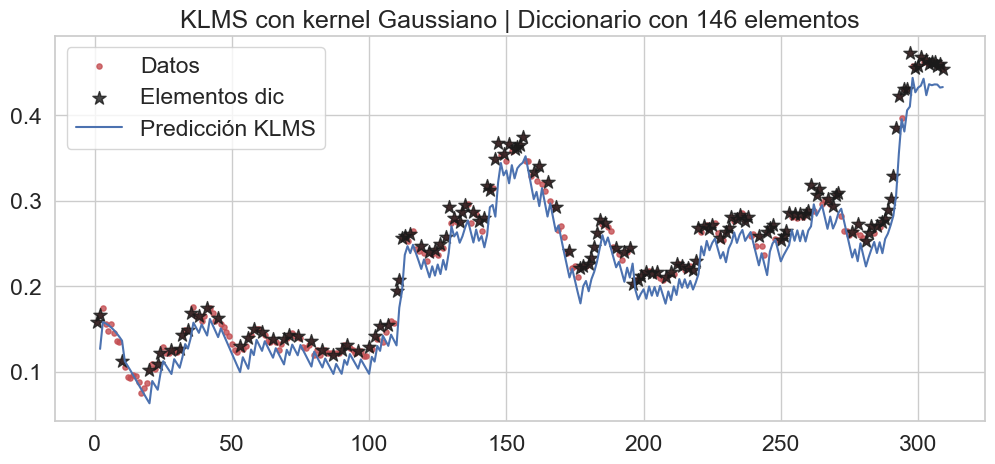

In [47]:
# total datos
plt.scatter(x, y, c='r', alpha=0.8, s=14, label='Datos')
plt.scatter(D[:, 0], y[D[:, 0].astype(int) - 1], c='k',marker='*', alpha=0.8, s=100, label='Elementos dic')
plt.plot(x[1:], y_klms[1:], label='Predicción KLMS')
plt.legend()
plt.title('KLMS con kernel Gaussiano | Diccionario con {} elementos'.format(D.shape[0]));

# Support Vector Machines (SVM)

Primero mostramos un ejemplo de regresión y luego uno de clasificación.

## Support vector regressor

In [48]:
from sklearn.svm import SVR

### Interpolación

In [49]:
# inter | pred (interpolación y predicción)
mode = 'inter'

prop = 0.4
if mode == 'inter':
    train_points = np.sort(np.random.choice(len(x), int(len(x) * prop), replace=False))
elif mode == 'pred':
    train_points = np.arange(len(x) * prop).astype(int)

    
# SVM    

# instanciamos
svr = SVR(kernel='rbf', C=1, epsilon=0.01, gamma=0.002)

# entrenamiento 
svr.fit(x[train_points], y[train_points]) 

# predicción
y_hat_svr_inter = svr.predict(x)

__Graficamos__

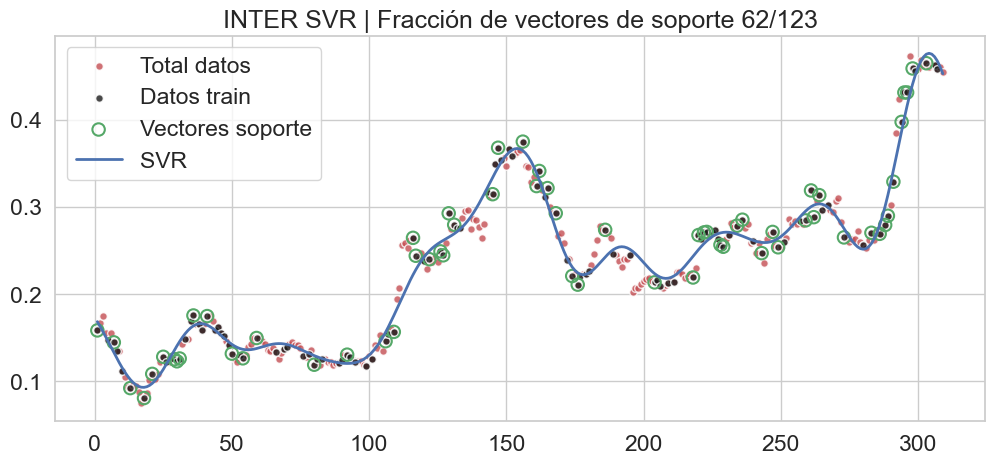

In [50]:
# total datos
plt.scatter(x, y, c='r', alpha=0.8, s=30, label='Total datos', edgecolor='w')

# datos entrenamiento
plt.scatter(
    x[train_points],
    y[train_points],
    c='k',
    alpha=0.8,
    s=30,
    label='Datos train',
    edgecolor='w')

# vectores de soporte
plt.scatter(
    x[train_points][svr.support_],
    y[train_points][svr.support_],
    edgecolors='g',
    lw=1.5,
    s=80,
    facecolor='none',
    alpha=1,
    label='Vectores soporte')

# predicción svr
plt.plot(x, y_hat_svr_inter, label='SVR', lw=2)
plt.legend()
plt.title('{2} SVR | Fracción de vectores de soporte {1}/{0}'.format(
    len(x[train_points]), len(svr.support_), mode.upper()));

## Support vector classifier

In [59]:
from sklearn.svm import SVC

__cargar datos, tomamos solo una fracción (solo para ilustrar mejor)__

In [60]:
from sklearn.model_selection import train_test_split

# cargar datos
data = np.loadtxt('../datos/datos_reg_log.txt', delimiter=',')

# Subconjunto para grafico más claro
n = 50 
data = data[:, np.random.choice(data.shape[1], n, replace=False)]

# split train-test
X_train, X_test, y_train, y_test = train_test_split(
    data[:2, :].T, data[2, :].T, test_size=0.33)

__Declaración del clasificador y entrenamiento__

In [65]:
# instanciar
svc = SVC(kernel='rbf', C=1, gamma=0.1)

# entrenamiento
svc.fit(X_train, y_train)

# test
y_pred = svc.predict(X_test)

__Plotear region de classificación y vectores de soporte__

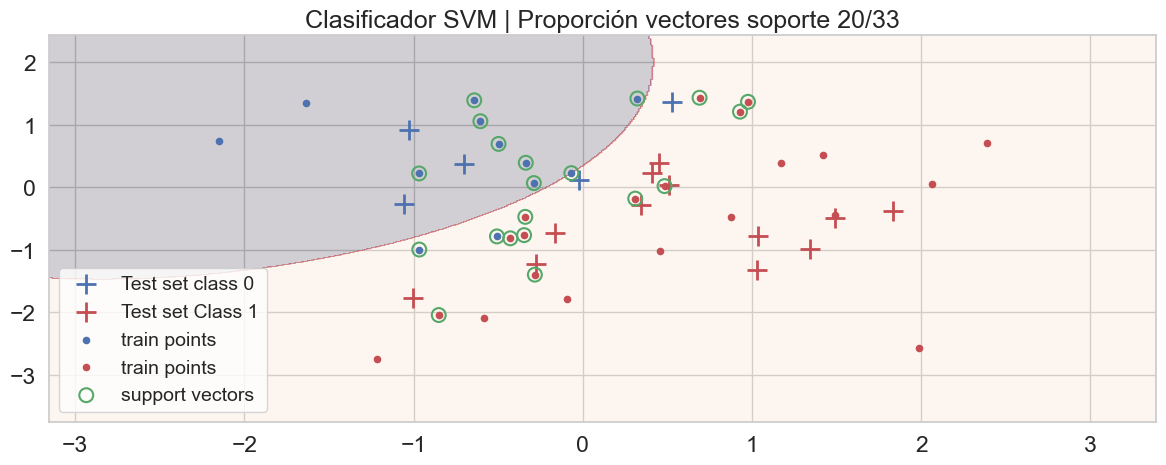

In [66]:
# malla de puntos para graficar region
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# clasificar grid
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.2, zorder=1)

plt.scatter(
    X_test[y_test == 0, 0],
    X_test[y_test == 0, 1],
    c='b',
    marker='+',
    linewidth=2,
    s=200,
    label='Test set class 0',
    zorder=2)

plt.scatter(
    X_test[y_test == 1, 0],
    X_test[y_test == 1, 1],
    c='r',
    marker='+',
    s=200,
    linewidth=2,
    label='Test set Class 1',
    zorder=2)

plt.scatter(X_train[y_train==0, 0],
            X_train[y_train==0, 1],
            marker='.',
            c='b',
            s=80,
            label='train points',
            zorder=1)

plt.scatter(X_train[y_train==1, 0],
            X_train[y_train==1, 1],
            marker='.',
            c='r',
            s=80,
            label='train points',
            zorder=1)

plt.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    edgecolors='g',
    lw=1.5,
    s=100,
    facecolor='none',
    alpha=1,
    label='support vectors',
    zorder=3)

plt.legend(fontsize=14)
plt.title('Clasificador SVM | Proporción vectores soporte {}/{}'.format(len(svc.support_), len(X_train)))

plt.tight_layout()

### Real data set: breast cancer wisconsin

__importar datos__

In [67]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


__Normalizar | blanquear (normalizar para tener media 0 y varianza unitaria)__

In [68]:
data.data -= data.data.mean(axis=0)
data.data /= data.data.std(axis=0)

__dividir en train y test__

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.33, random_state=42)

__declaracion del clasificador y entrenamiento__

In [79]:
svc = SVC(kernel='rbf', C=8, gamma='auto')

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

__fracción de vectores de soporte__

In [80]:
print('Fraccion de vectores de soporte {}/{}'.format(len(svc.support_), len(X_train)))

Fraccion de vectores de soporte 71/381


__performance__

In [81]:
from sklearn.metrics import accuracy_score

print('Accuracy en conjunto de test {:f}'.format(accuracy_score(y_test, y_pred)))

Accuracy en conjunto de test 0.978723
